In [1]:
import os
import cv2
import glob
import torch
import numpy as np
import torchvision
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data Loading

In [2]:
data_path = "../data/img_align_celeba/"

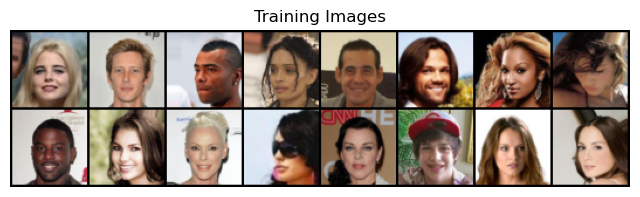

In [3]:
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


#### Model

In [4]:
import torch
import numpy as np
import torch.nn as nn

'''
Source code from 
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 
and 
https://arxiv.org/pdf/1511.06434.pdf

'''
latent_dim = 100
in_channels = [512, 256, 128, 64]
kernel_size = [4,4,4,4,4]
stride = [1,2,2,2,2]
padding = [0,1,1,1,1]
out_channels = 3


class Generator(nn.Module):
    def __init__(self,latent_dim = latent_dim, in_channels = in_channels, kernel_size = kernel_size, stride = stride, padding = padding, out_channels = out_channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.out_channels = out_channels

        self.main = nn.Sequential(
            ###
            nn.ConvTranspose2d(self.latent_dim,self.in_channels[0],self.kernel_size[0], self.stride[0], self.padding[0], bias=False),
            nn.BatchNorm2d(self.in_channels[0]),
            nn.ReLU(True),
            ###
            nn.ConvTranspose2d(self.in_channels[0],self.in_channels[1],self.kernel_size[1], self.stride[1], self.padding[1], bias=False),
            nn.BatchNorm2d(self.in_channels[1]),
            nn.ReLU(True),
            ###
            nn.ConvTranspose2d(self.in_channels[1],self.in_channels[2],self.kernel_size[2], self.stride[2], self.padding[2], bias=False),
            nn.BatchNorm2d(self.in_channels[2]),
            nn.ReLU(True),
            ###
            nn.ConvTranspose2d(self.in_channels[2],self.in_channels[3],self.kernel_size[3], self.stride[3], self.padding[3], bias=False),
            nn.BatchNorm2d(self.in_channels[3]),
            nn.ReLU(True),
            ###
            nn.ConvTranspose2d(self.in_channels[3],self.out_channels,self.kernel_size[4], self.stride[4], self.padding[4], bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels = in_channels, kernel_size = kernel_size, stride = stride, padding = padding, out_channels = out_channels):
        super(Discriminator, self).__init__()
        self.in_channels = np.flip(in_channels)
        self.kernel_size = np.flip(kernel_size)
        self.stride = np.flip(stride)
        self.padding = np.flip(padding)
        self.out_channels = out_channels

        self.main = nn.Sequential(
            ###
            nn.Conv2d(self.out_channels,self.in_channels[0],self.kernel_size[0], self.stride[0], self.padding[0], bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            ###
            nn.Conv2d(self.in_channels[0],self.in_channels[1],self.kernel_size[1], self.stride[1], self.padding[1], bias=False),
            nn.BatchNorm2d(self.in_channels[1]),
            nn.LeakyReLU(0.2, inplace=True),
            ###
            nn.Conv2d(self.in_channels[1],self.in_channels[2],self.kernel_size[2], self.stride[2], self.padding[2], bias=False),
            nn.BatchNorm2d(self.in_channels[2]),
            nn.LeakyReLU(0.2, inplace=True),
            ###
            nn.Conv2d(self.in_channels[2],self.in_channels[3],self.kernel_size[3], self.stride[3], self.padding[3], bias=False),
            nn.BatchNorm2d(self.in_channels[3]),
            nn.LeakyReLU(0.2, inplace=True),
            ###
            nn.Conv2d(self.in_channels[3],1,self.kernel_size[4], self.stride[4], self.padding[4], bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [5]:
netG = Generator().to(device)
netD = Discriminator().to(device)
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Training

In [6]:
from torchvision.utils import make_grid

def infer(generated_sample_count, generator):
    r"""
    Method to save the generated samples
    :param generated_sample_count: Filename to save the output with
    :param generator: Generator model with trained parameters
    :return:
    """
    fake_im_noise = torch.randn((225, 100, 1,1), device=device)
    fake_ims = generator(fake_im_noise)
    ims = torch.clamp(fake_ims, -1., 1.).detach().cpu()
    ims = (ims + 1) / 2
    grid = make_grid(ims, nrow=15)
    img = torchvision.transforms.ToPILImage()(grid)
    if not os.path.exists('samples'):
        os.mkdir('samples')
    img.save('samples/{}.png'.format(generated_sample_count))

In [7]:
from torch.optim import Adam
NUM_EPOCHS = 10
LATENT_DIM = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.train()
discriminator.train()

optimizer_generator = Adam(generator.parameters(), lr=1E-4, betas=(0.5, 0.999))
optimizer_discriminator = Adam(discriminator.parameters(), lr=1E-4, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()
steps = 0
generated_sample_count = 0
for epoch_idx in range(NUM_EPOCHS):
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []
    for im in tqdm(dataloader):
        real_ims = im[0].float().to(device)
        batch_size = real_ims.shape[0]
        optimizer_discriminator.zero_grad()
        fake_im_noise = torch.randn((batch_size, LATENT_DIM, 1,1), device=device)
        fake_ims = generator(fake_im_noise)
        real_label = torch.ones((batch_size, 1), device=device)
        fake_label = torch.zeros((batch_size, 1), device=device)
        
        disc_real_pred = discriminator(real_ims)
        disc_fake_pred = discriminator(fake_ims.detach())
        disc_real_loss = criterion(disc_real_pred.reshape(-1), real_label.reshape(-1))
        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())

        disc_fake_loss = criterion(disc_fake_pred.reshape(-1), fake_label.reshape(-1))
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())
        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_loss.backward()
        optimizer_discriminator.step()

        optimizer_generator.zero_grad()
        fake_im_noise = torch.randn((batch_size, LATENT_DIM, 1,1), device=device)
        fake_ims = generator(fake_im_noise)
        disc_fake_pred = discriminator(fake_ims)
        gen_fake_loss = criterion(disc_fake_pred.reshape(-1), real_label.reshape(-1))
        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())
            
        # Save samples
        if steps % 50 == 0:
            with torch.no_grad():
                generator.eval()
                infer(generated_sample_count, generator)
                generated_sample_count += 1
                generator.train()
        ############
        steps += 1
    print('Finished epoch:{} | Generator Loss : {:.4f} | Discriminator Loss : {:.4f} | '
            'Discriminator real pred : {:.4f} | Discriminator fake pred : {:.4f}'.format(
        epoch_idx + 1,
        np.mean(generator_losses),
        np.mean(discriminator_losses),
        np.mean(mean_real_dis_preds),
        np.mean(mean_fake_dis_preds),
    ))
print('Done Training ...')




100%|██████████| 12663/12663 [04:09<00:00, 50.77it/s]


Finished epoch:1 | Generator Loss : 3.9385 | Discriminator Loss : 0.1900 | Discriminator real pred : 0.7032 | Discriminator fake pred : 0.5316


100%|██████████| 12663/12663 [04:09<00:00, 50.81it/s]


Finished epoch:2 | Generator Loss : 4.4371 | Discriminator Loss : 0.1368 | Discriminator real pred : 0.7118 | Discriminator fake pred : 0.5221


100%|██████████| 12663/12663 [04:15<00:00, 49.48it/s]


Finished epoch:3 | Generator Loss : 4.6455 | Discriminator Loss : 0.1202 | Discriminator real pred : 0.7143 | Discriminator fake pred : 0.5192


100%|██████████| 12663/12663 [04:21<00:00, 48.46it/s]


Finished epoch:4 | Generator Loss : 4.9444 | Discriminator Loss : 0.1048 | Discriminator real pred : 0.7164 | Discriminator fake pred : 0.5168


100%|██████████| 12663/12663 [04:22<00:00, 48.27it/s]


Finished epoch:5 | Generator Loss : 5.2482 | Discriminator Loss : 0.0950 | Discriminator real pred : 0.7181 | Discriminator fake pred : 0.5148


100%|██████████| 12663/12663 [04:22<00:00, 48.27it/s]


Finished epoch:6 | Generator Loss : 5.5116 | Discriminator Loss : 0.0847 | Discriminator real pred : 0.7195 | Discriminator fake pred : 0.5132


100%|██████████| 12663/12663 [04:25<00:00, 47.61it/s]


Finished epoch:7 | Generator Loss : 5.7747 | Discriminator Loss : 0.0772 | Discriminator real pred : 0.7208 | Discriminator fake pred : 0.5117


100%|██████████| 12663/12663 [04:15<00:00, 49.61it/s]


Finished epoch:8 | Generator Loss : 5.9743 | Discriminator Loss : 0.0710 | Discriminator real pred : 0.7215 | Discriminator fake pred : 0.5110


100%|██████████| 12663/12663 [04:19<00:00, 48.84it/s]


Finished epoch:9 | Generator Loss : 6.1674 | Discriminator Loss : 0.0713 | Discriminator real pred : 0.7222 | Discriminator fake pred : 0.5102


100%|██████████| 12663/12663 [04:32<00:00, 46.45it/s]

Finished epoch:10 | Generator Loss : 6.3586 | Discriminator Loss : 0.0630 | Discriminator real pred : 0.7228 | Discriminator fake pred : 0.5095
Done Training ...


In [9]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
img_list = os.listdir('./samples')
#slecting only 200 images with step of 10
ims = [[plt.imshow(Image.open('./samples/' + str(i)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


Animation size has reached 21036085 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


(-0.5, 991.5, 991.5, -0.5)

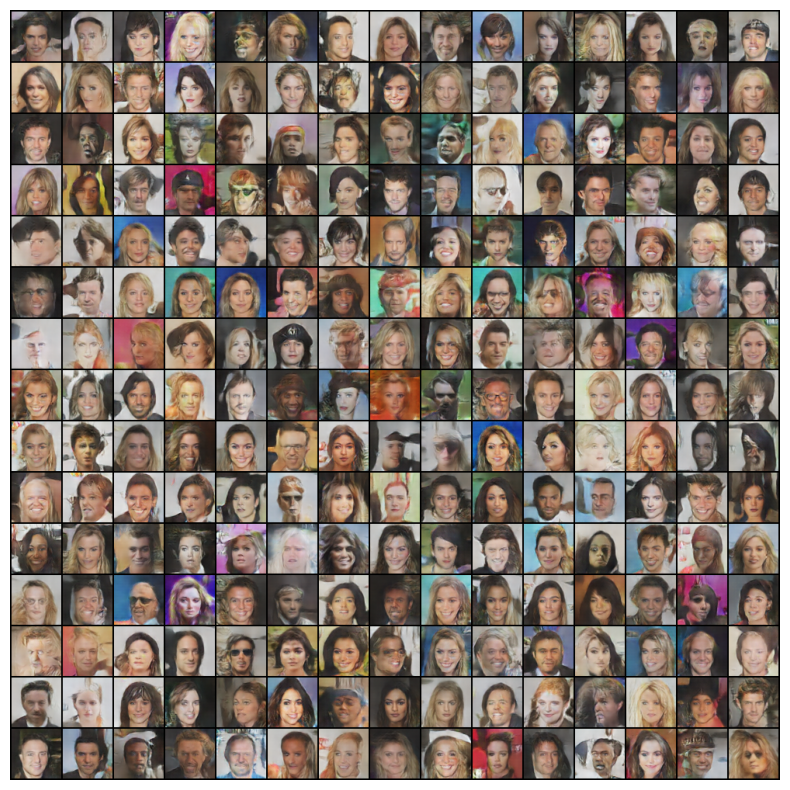

In [67]:
with torch.no_grad():
    generator.eval()
    infer(generated_sample_count, generator)
    generated_sample_count += 1
    generator.train()
out = plt.imread("/home/akansh-i2sc/Desktop/ExplainableAI/DCGAN-Pytorch/notebooks/samples/0.png")
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.axis('off')